In [2]:
import matplotlib.pyplot as plt
import subprocess as sb
from pathlib import Path
from timeit import timeit
from math import floor
from math import sqrt
from tqdm import tqdm
import copy

from typing import Tuple, Self, List


In [3]:
cur_dir = Path.cwd()
project_dir  = cur_dir.parent.parent

In [ ]:
# def calc_time(count: int, size: int) -> float:
#     result = sb.run(
#         f'{project_dir}/build/gen {size} -c {count}'.split(),
#         capture_output=True
#     )
#     time = timeit(
#         lambda: sb.run(
#             f'{project_dir}/build/fr -mecm'.split(),
#             input=result.stdout,
#             capture_output=True
#         ),
#         number=1
#     )
#     return time

def calc_time(count: int, size: int) -> List[float]:
    arr = []
    batch = min(10, count)
    batch_count = int(count / batch)
    left = count
    for _ in tqdm(range(batch_count)):
        cur_count = min(batch, left)
        left -= cur_count
        result = sb.run(
            f'{project_dir}/build/gen {size} -c {cur_count}'.split(),
            capture_output=True
        )
        result = sb.run(
            f'{project_dir}/build/fr -mecm -t'.split(),
            input=result.stdout,
            capture_output=True
        )
        for line in result.stdout.decode().split('\n')[:-3]:
            arr.append(float(line.split()[-2]))

    return arr

class Diag:
    def __init__(self, arr: List[float], bucket_count: float,
        slr=0, sll=0, min_backet_size=0
    ):
        self.arr = copy.copy(arr)
        def build_diag(arr, bucket_count):
            min_ = min(arr)
            max_ = max(arr)
            bucket_size = max(
                min_backet_size,
                (max_ - min_) / bucket_count
            )
            diag = [0]
            for elem in arr:
                q = floor((elem - min_) / bucket_size)
                if len(diag) <= q:
                    diag += [0] * (q - len(diag) + 1)
                diag[q] += 1
            return min_, max_, bucket_size, diag

        self.min_, self.max_, self.bucket_size, self.diag = \
                                            build_diag(arr, bucket_count)
        sum = 0
        new_min = 0
        new_max = 0
        for q, el in enumerate(self.diag):
            sum += el
            if new_min == 0 and sll < sum / len(arr):
                new_min = new_max = self.min_ + q * self.bucket_size
            if (len(arr) - sum) / len(arr) < slr:
                self.diag = self.diag[:q]
                new_max = self.min_ + q * self.bucket_size
                break
        print(new_max)
        new_arr = [q for q in arr if new_min < q and q < new_max]
        self.min_, self.max_, self.bucket_size, self.diag = \
                                        build_diag(new_arr, bucket_count)

    def get_x(self):
        return [
            self.min_ + q * self.bucket_size
            for q in range(len(self.diag))
        ]

    def get_h(self):
        return self.diag


In [ ]:
arr_4b_1p = calc_time(1500, 4)

100%|██████████| 150/150 [02:49<00:00,  1.13s/it]


265.69


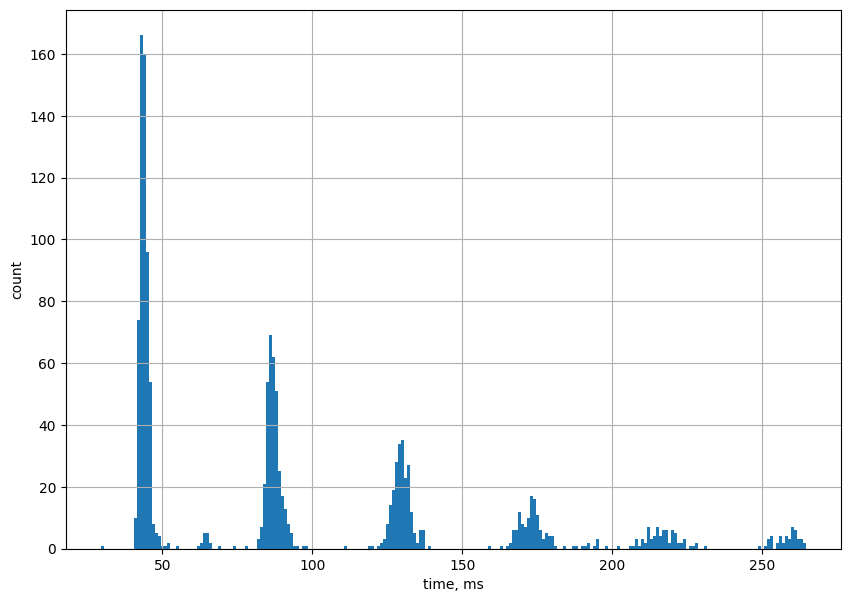

In [14]:
diag = Diag(arr_4b_1p, 1000, sll=0.0, slr=0.05, min_backet_size=1)

plt.figure(figsize=(10, 7))
plt.bar(diag.get_x(), diag.get_h(), width=diag.bucket_size)
plt.xlabel('time, ms')
plt.ylabel('count')
plt.grid()

In [8]:
arr_8b_1p = calc_time(1000, 8)

100%|██████████| 100/100 [11:34<00:00,  6.95s/it]


1514.582


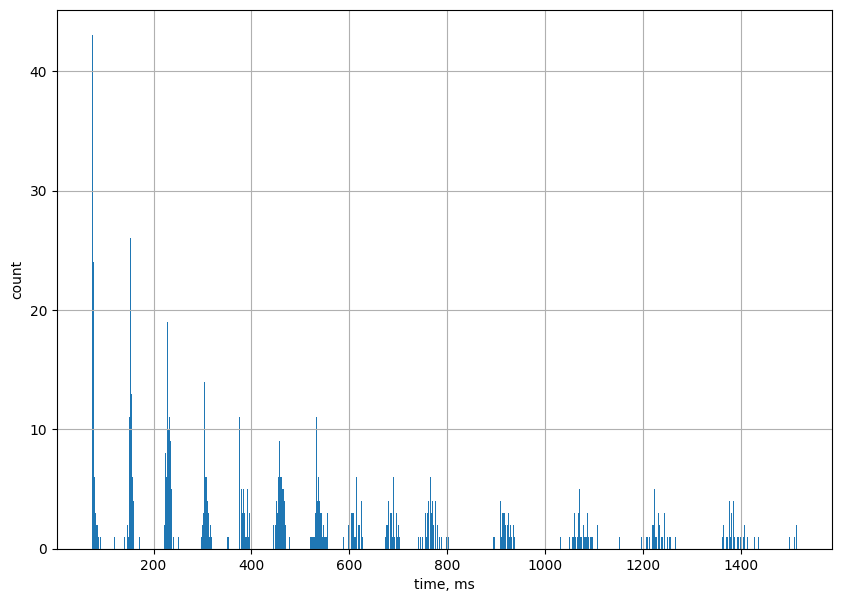

In [17]:
diag = Diag(arr_8b_1p, 1000, sll=0.0, slr=0.1, min_backet_size=1)

plt.figure(figsize=(10, 7))
plt.bar(diag.get_x(), diag.get_h(), width=diag.bucket_size)
plt.xlabel('time, ms')
plt.ylabel('count')
plt.grid()

100%|██████████| 11/11 [08:06<00:00, 44.22s/it] 


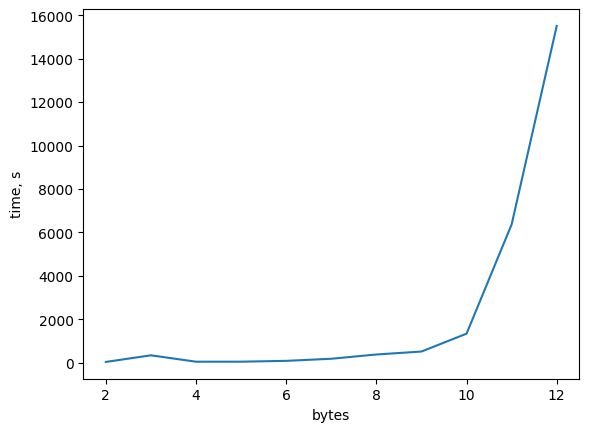

In [ ]:
def build_dep():
    time_arr = []
    byte_array = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    for q in tqdm(byte_array):
        arr = calc_time(10, q)
        mean = sum(arr) / len(arr)
        disp = sqrt(sum([(mean - w)**2 for w in arr])) / len(arr)
        new_arr = [w for w in arr if w < mean + disp]
        ct = sum(new_arr) / len(new_arr)
        time_arr.append(ct)


    plt.figure(figsize=(10, 7))
    plt.plot(byte_array, time_arr)
    plt.xlabel('bytes')
    plt.ylabel('time, s')
    plt.grid()
build_dep()